# LSTM Stock v2

mutiple value features

In [1]:
%matplotlib inline
from pandas_datareader import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
print(sys.version_info)
print(tf.__version__)

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
1.3.0


## Get Google Stock data from google finance

In [2]:
# As usual, you know what I mean
goog = data.DataReader('GOOG', start='2010', end = "2017",
                       data_source='google')
goog.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2016-10-17,779.80,785.85,777.50,779.96,1092973
2016-10-18,787.85,801.61,785.56,795.26,2056903
2016-10-19,798.86,804.63,797.64,801.56,1766798
2016-10-20,803.30,803.97,796.03,796.97,1757528
2016-10-21,795.00,799.50,794.00,799.37,1266181
2016-10-24,804.90,815.18,804.82,813.11,1697514
2016-10-25,816.68,816.68,805.14,807.67,1576404
2016-10-26,806.34,806.98,796.32,799.07,1647733
2016-10-27,801.00,803.49,791.50,795.35,2749221


## Prepare labels

use the next day close value as label

In [3]:
goog["Label"] = goog["Close"].shift(-1)
goog.dropna(inplace=True)
goog.head()

,Open,High,Low,Close,Volume,Label
Date,,,,,,
2016-10-17,779.80,785.85,777.50,779.96,1092973,795.26
2016-10-18,787.85,801.61,785.56,795.26,2056903,801.56
2016-10-19,798.86,804.63,797.64,801.56,1766798,796.97
2016-10-20,803.30,803.97,796.03,796.97,1757528,799.37
2016-10-21,795.00,799.50,794.00,799.37,1266181,813.11


In [4]:
len(goog)

250

In [5]:
data = goog.values

## Global Model parameters

In [6]:
rnn_unit: int = 10
input_size: int = 5
output_size: int = 1
learning_rate: float = 0.0006

In [7]:
def get_train_data(batch_size=60,time_step=20,train_begin=0,train_end=200):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  #
    train_x,train_y=[],[]   #
    for i in range(len(normalized_train_data)-time_step):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:input_size]
        y=normalized_train_data[i:i+time_step,input_size,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index, np.array(train_x), np.array(train_y)

In [8]:
def get_test_data(time_step=20,test_begin=200):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  #
    size=(len(normalized_test_data)+time_step-1)//time_step  #
    test_x,test_y=[],[]  
    for i in range(size-1):
        x=normalized_test_data[i*time_step:(i+1)*time_step,:input_size]
        y=normalized_test_data[i*time_step:(i+1)*time_step,input_size]
        test_x.append(x.tolist())
        test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:input_size]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,input_size]).tolist())
    return mean,std,test_x,test_y

## Define NN Parameters

In [9]:
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }

## Define LSTM

In [10]:
def lstm(X):     
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']  
    input=tf.reshape(X,[-1,input_size])  #
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32) 
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [11]:
def train_lstm(batch_size=80,time_step=15,train_begin=0,train_end=200):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size,time_step,train_begin,train_end)
    pred,_=lstm(X)
    #Loss function
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(learning_rate).minimize(loss)
    saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)
    # module_file = tf.train.latest_checkpoint(".")    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # saver.restore(sess, module_file)
        #Repeate 2000 times
        for i in range(2000):
            for step in range(len(batch_index)-1):
                _, loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]}) 
            if i % 200==0:
                print(i,loss_)
                print("save model:",saver.save(sess,'stock2.model',global_step=i))

In [13]:
train_lstm()

0 17.8178
save model: stock2.model-0
200 0.0401946
save model: stock2.model-200
400 0.027042
save model: stock2.model-400
600 0.0220925
save model: stock2.model-600
800 0.0192423
save model: stock2.model-800
1000 0.0177678
save model: stock2.model-1000
1200 0.0168812
save model: stock2.model-1200
1400 0.0161858
save model: stock2.model-1400
1600 0.0155409
save model: stock2.model-1600
1800 0.0148406
save model: stock2.model-1800


In [12]:
def prediction(time_step=20):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    mean,std,test_x,test_y=get_test_data(time_step)
    pred,_=lstm(X)     
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #restore parameter
        module_file = tf.train.latest_checkpoint(".")
        saver.restore(sess, module_file) 
        test_predict=[]
        for step in range(len(test_x)-1):
            prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
            predict=prob.reshape((-1))
            test_predict.extend(predict)
        test_y=np.array(test_y)*std[input_size]+mean[input_size]
        test_predict=np.array(test_predict)*std[input_size]+mean[input_size]
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])
        
        plt.plot(list(range(len(test_predict))), test_predict, color='b')
        plt.plot(list(range(len(test_y))), test_y,  color='r')
        plt.legend(["predict", "reals"])

INFO:tensorflow:Restoring parameters from ./stock2.model-1800


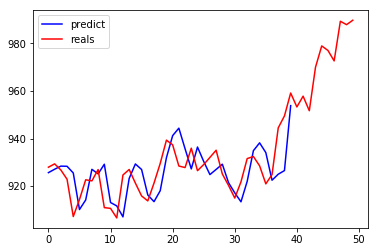

In [13]:
prediction()